# Clustering with UMAP 

This is an initial test notebook to cluster transit candidates using the Uniform Manifold Approximation and Projection ([UMAP](https://arxiv.org/pdf/1802.03426.pdf)) technique. 
- Reading in our output data
- Cross-referencing any 

## Importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

os.chdir("../../scripts")
from analysis_tools_cython import *
#from scripts.post_processing import *
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
SEED = 42

## Importing files

We'll be importing the output data from the search, but also the current catalog of Eclipsing Binaries (EBs). 
- Where EBs will lie on this projection might give as a better picture of other candidates with similar properties, and help in clustering out false-positive transits.

In [2]:
data = pd.read_csv('test.csv')

# data = get_output("output_log/test_s6.txt")
# metadata = get_metadata("lc_metadata/metadata_sector_6.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
ebs_30min = pd.read_csv("catalogs/eb_cat.txt")
#toi_list = pd.read_csv("catalogs/csv-file-toi-catalog.csv", skiprows=4)

In [ ]:
data.head()

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
ebs_in_data = data[(data["TIC_ID"].isin(ebs_30min["ID"]))]
ebs_in_data

In [ ]:
tois_in_data = merged_df[(merged_df["ticid"].isin(toi_list["TIC"]))]

Add a column that identifies the known EB's in the data:

In [ ]:
data.loc[ebs_in_data.index, "known_class"] = "eb"
#merged_df.loc[tois_in_data.index, "known_class"] = "toi"
data["known_class"].fillna(value=False, inplace=True)

In [ ]:
interested_region = data[
    (data.transit_prob == "maybeTransit")
    & (data.snr <= -5)
]

In [ ]:
reducer = umap.UMAP(random_state=SEED)

In [ ]:
features = ["snr", "asym_score", "time", "depth", "duration"]
# "peak_lspower", "time", "mstat"

In [ ]:
new_data = interested_region[features]
scaled_data = StandardScaler().fit_transform(new_data)

Explore Lomb-Scargle features which might be a good feature for the clusters:
- Peak power 
- Peak frequency...

embedding: transform first, reduce after

- eg: reducer = fit(data)
- embedding = reducer.transform(data)

In [ ]:
embedding = reducer.fit_transform(scaled_data)
embedding.shape

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.7)
# c=[sns.color_palette()[x] for x in merged_df.known_class.map({"toi":0, "eb":1})])
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the output data", fontsize=18)
plt.xlabel("latent space x", fontsize=12)
plt.ylabel("latent space y", fontsize=12)

distances on this latent space don't matter...
- don't map directly back to the high-dimensional space.
- find out what these spaces are!

In [ ]:
new_data.shape

In [ ]:
embedding.shape

In [ ]:
new_data["embedding_x"] = embedding[:, 0]
new_data["embedding_y"] = embedding[:, 1]

In [ ]:
new_data

### Example: Recovering the false-positives
Let's take 80 of the closest neighbouring points according to `(0,-6)` coordinates on the UMAP projection.

In [ ]:
distances = np.linalg.norm(embedding - np.array([0, -5]), axis=1)
new_data["dist"] = distances
closest = new_data.iloc[np.argsort(distances)[:80]]

In [ ]:
closest

In [ ]:
files = data.loc[data.index & closest.index].abs_path
#path = "/storage/astro2/phrdhx/tesslcs/lc_arraydata/sector_6/"
#path2 = "/storage/astro2/phrdhx/tesslcs/tesslcs_sector_6_104/"

In [ ]:
files.head(2).values

In [44]:
for i in files:
    plt.figure(figsize=(10, 4))
    lc, lc_info = import_lightcurve(i)
    plt.scatter(lc_data['TIME'], lc_data["CORR_FLUX"], s=10)
    plt.title(f"TIC {lc_info[0]}")
    plt.show()

NameError: name 'import_lightcurve' is not defined

<Figure size 720x288 with 0 Axes>

In [207]:
a = merged_df.loc[data.index & new_data.index]
a

,file,ticid,ra,dec,magnitude,camera,chip,sector,signal,snr,...,width2,duration,depth,peak_lspower,mstat,transit_prob,ID,mstat_xrp,astat,known_class
154,tesslc_97801854.pkl,97801854,90.359076,16.797994,14.1944,1,4,6,-22.933559,-8.207642,...,0.109361,0.374996,-0.032587,0.036833,0.528,maybeTransit,97801854,-0.039,0.076041,False
208,tesslc_350582006.pkl,350582006,87.055791,-57.391417,14.4372,4,2,6,-5.783428,-5.565657,...,0.000191,0.145833,-0.006334,0.014520,0.061,maybeTransit,350582006,0.251,0.043778,False
900,tesslc_294784620.pkl,294784620,71.354497,-71.092564,14.3273,4,3,6,-7.333348,-5.953144,...,0.005732,0.374996,-0.004865,0.020404,0.038,maybeTransit,294784620,0.278,0.235063,False
950,tesslc_24722209.pkl,24722209,81.484835,-5.991577,5.8311,1,1,6,-7.673912,-5.386740,...,0.070428,0.083331,-0.000922,0.091683,-0.077,maybeTransit,24722209,-0.135,0.350441,False
985,tesslc_156195744.pkl,156195744,86.387879,10.005836,14.2071,1,4,6,-11.120042,-6.210929,...,0.304273,0.583323,-0.010650,0.019098,0.151,maybeTransit,156195744,-0.483,0.043086,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778599,tesslc_264460005.pkl,264460005,81.166478,1.757429,12.9876,1,1,6,-9.506305,-5.663818,...,0.017130,0.145830,-0.005932,0.097537,0.208,maybeTransit,264460005,0.191,0.267623,toi
2778948,tesslc_365779508.pkl,365779508,81.923894,9.822392,12.5437,1,4,6,-20.773472,-8.844357,...,0.048287,0.312492,-0.009722,0.026547,0.410,maybeTransit,365779508,-0.068,0.121081,False
2778950,tesslc_144611697.pkl,144611697,84.547647,6.976661,12.8742,1,4,6,-23.387310,-12.668007,...,0.048334,0.124997,-0.027937,0.032187,0.530,maybeTransit,144611697,0.533,0.000000,False
2779201,tesslc_140604181.pkl,140604181,90.622212,8.237346,12.1715,1,4,6,-14.064232,-6.748508,...,0.142723,0.562494,-0.003855,0.053417,0.196,maybeTransit,140604181,-0.195,-0.017442,False


In [208]:
b = a.loc[a.known_class == "eb"]

**The code below returns the lightcurves of the EB's. Commenting out due to number of outputs**

In [209]:
# for j in b.file:

#     npz = ".npz"
#     npz_file = j.split('.pkl')[0]
#     npz_file += npz
#     #print(os.path.join(arraydata_path,f'{i}'))
#     file_path = os.path.join(path,f'{npz_file}')
#     arraydata = np.load(file_path)

#     file_path2 = glob.glob(os.path.join(path2,f'**/{j}'))[0]
#     lc , _ = import_XRPlightcurve(file_path2, sector=6)

#     fig, ax = plt.subplots(1,2,figsize=(15,3))
#     ax[0].scatter(arraydata['time'],arraydata['flux'],s=8)
#     ax[1].scatter(lc['time'],normalise_flux(lc['corrected flux']),s=8)
#     fig.show()

### Plotting EBs on UMAP projection

In [210]:
ebs = new_data.loc[b.index & new_data.index]

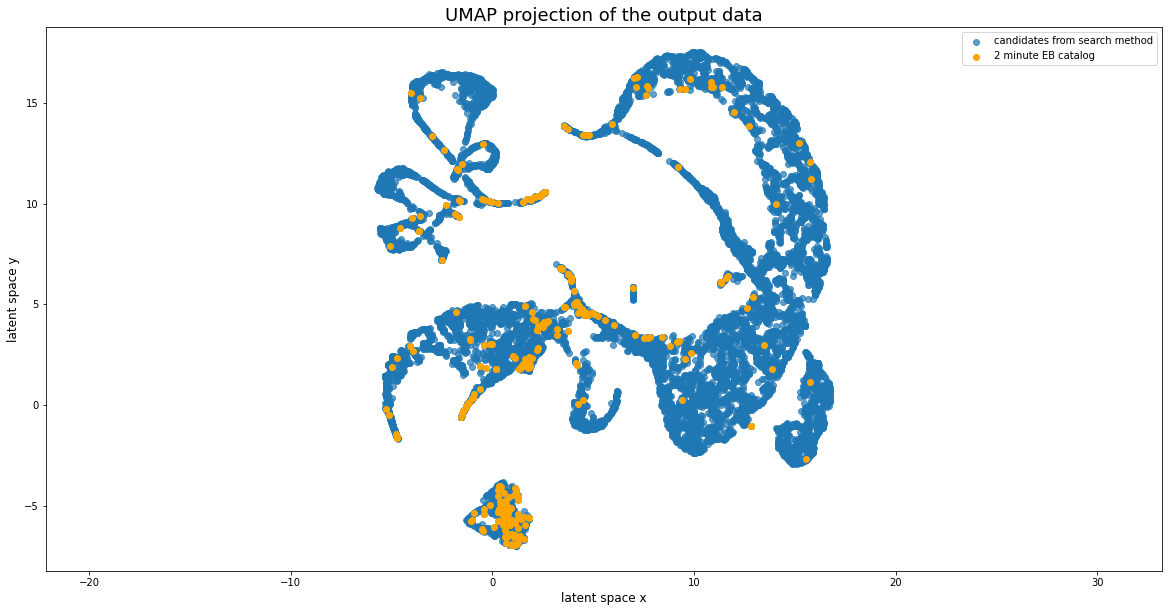

In [211]:
plt.figure(figsize=(20, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], alpha=0.7, label="candidates from search method"
)
# c=[sns.color_palette()[x] for x in data.transit_prob.map({"maybeTransit":0, "artefact":1})])
plt.scatter(ebs.embedding_x, ebs.embedding_y, c="orange", label="2 minute EB catalog")
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the output data", fontsize=18)
plt.xlabel("latent space x", fontsize=12)
plt.ylabel("latent space y", fontsize=12)
plt.legend()
plt.savefig(f"umap_projections/{'_'.join(features)}", dpi=500)

- The cluster at ~ `(0,-5)` is likely EBs, as a fair amount of known EBs fall in this category. 
- However, EBs also fall around other areas on this UMAP, which is an interesting result.
    - We could conclude that this is due to understating/overstating the features with our data, and that maybe a different combination of features might supply improved results.